In [1]:
import sys; sys.path.insert(0, '../../')
from definitions import *
from notebooks.nb_imports import *

In [2]:
from experiments.utils import create_run_frame
from experiments.analyse import analyse
from src.visualization.critial_difference import plot_cd_diagram, wilcoxon_holm

This notebook is to give an example of how to analyse the experiment output. Note the results given are on a subset of the data and is just meant for explanatory purposes. These are **not** the full results on all datasets that are given in the paper. 


# Experiment evaluation as a single function
Here we give a brief overview of how to extract the information from an experiment run, and how to produce the CD-diagram plots as seen in the paper. 

We actually provide a handy function for analysing the data below, but we give also the steps used in generating this, in case you wish to do something more specialised/some additional analysis to what was given in the paper. 

NOTE: The null hypothesis over all classifiers cannot be rejected.


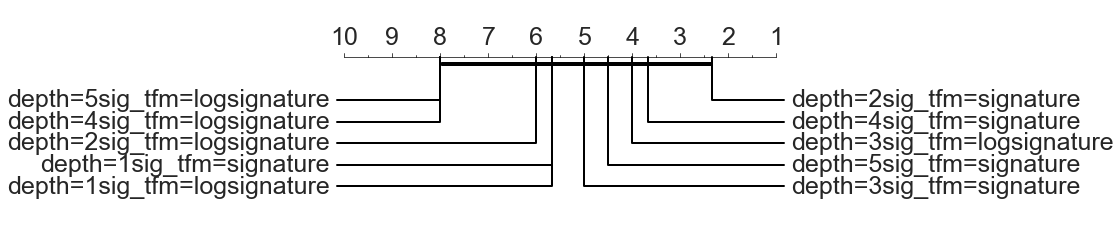

In [3]:
# This saves the test accuracy results, average ranks, and cd-diagram plots to an analysis folder in the experiment directory. 
ex_dir, config_name = RESULTS_DIR + '/depth_sig', 'depth_sig'
results, average_ranks = analyse(ex_dir, config_name)

In [4]:
results.head()

transform_id,depth=1sig_tfm=logsignature,depth=1sig_tfm=signature,depth=2sig_tfm=logsignature,depth=2sig_tfm=signature,depth=3sig_tfm=logsignature,depth=3sig_tfm=signature,depth=4sig_tfm=logsignature,depth=4sig_tfm=signature,depth=5sig_tfm=logsignature,depth=5sig_tfm=signature
ds_name,,,,,,,,,,
ERing,0.722222,0.722222,0.707407,0.714815,0.596296,0.670370,0.600000,0.722222,0.529630,0.688889
Epilepsy,0.376812,0.376812,0.311594,0.514493,0.565217,0.405797,0.282609,0.478261,0.398551,0.485507
JapaneseVowels,0.789189,0.789189,0.854054,0.883784,0.864865,0.856757,0.835135,0.848649,NaN,NaN


<br>
<br>

# Experiment evaluation in individual steps

## 1. Extract the experiment information

Start by creating a dataframe for the run that contains all configuration and metrics information.

In [38]:
df = create_run_frame(RESULTS_DIR + '/depth_sig')
df.head()

## 2. Create a unique `transform_id` column

This example is for the `depth_sig` configuration where we are interested in the performance for different depths with the signature and logsignature transformations.

Here we have varied the `depth` and `sig_tfm` variables. So first make a column `transform_id` that works as a unique identifier of these two things. 

In [41]:
df['transform_id'] = df['sig_tfm'].astype(str) + df['depth'].astype(str)

## 3. Take a maximum over the classifiers
We took the accuracy to be a maximum over the classifiers. Doing this reduces onto one entry for each unique `ds_name` and `transform_id` column. 

In [42]:
results = df.groupby(['ds_name', 'transform_id', 'clf'])['acc.test'].apply(max)
results = results.reset_index([1, 2]).drop('clf', axis=1)

## 4. Pivot to make a results matrix

Now we have a unique value for every `transform_id` and dataset. We just now need to get `transform_id` to be the column, and `ds_name` to be the index generating a 2x2 matrix of results, then we can generate the CD diagram.

In [43]:
pivoted = results.pivot_table(values='acc.test', index='ds_name', columns='transform_id', aggfunc=np.max)

This pivoted table is now in the form of the tables we give in the Appendix of the paper. 

In [44]:
pivoted.head()

transform_id,logsignature1,logsignature2,logsignature3,logsignature4,logsignature5,signature1,signature2,signature3,signature4,signature5
ds_name,,,,,,,,,,
ERing,0.722222,0.707407,0.596296,0.600000,0.529630,0.722222,0.714815,0.670370,0.722222,0.688889
Epilepsy,0.376812,0.311594,0.565217,0.282609,0.398551,0.376812,0.514493,0.405797,0.478261,0.485507
JapaneseVowels,0.789189,0.854054,0.864865,0.835135,NaN,0.789189,0.883784,0.856757,0.848649,NaN


## 5. Plot the CD-diagram

The `pivoted` table is in the format where we can use the `plot_cd_diagram` function, these are the results that is seen the paper.

NOTE: The null hypothesis over all classifiers cannot be rejected.


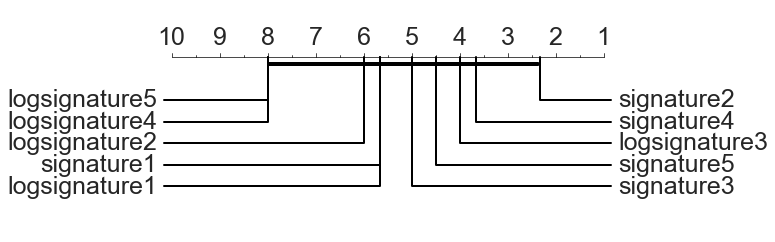

In [33]:
plot_cd_diagram(pivoted)

We can also extract the average ranks for each method, these correspond to the 'Average ranks' column that is given in all the tables in the Appendix of the paper. 

In [37]:
_, scores = wilcoxon_holm(pivoted)
scores

NOTE: The null hypothesis over all classifiers cannot be rejected.


transform_id
logsignature5    8.000000
logsignature4    8.000000
logsignature2    6.000000
signature1       5.666667
logsignature1    5.666667
signature3       5.000000
signature5       4.500000
logsignature3    4.000000
signature4       3.666667
signature2       2.333333
dtype: float64